# Week 6 · Day 3 — Initialization & Batch Normalization

## Why this matters

Deep nets can be unstable: too-small weights → vanishing gradients, too-large weights → exploding activations.
Initialization and batch normalization are two key tricks to make training smoother and faster.

---

## Theory Essentials

* **Initialization**

  * Poor init = gradients vanish/explode.
  * **Xavier/Glorot** (for tanh/sigmoid): variance = $1 / n$.
  * **He init** (for ReLU): variance = $2 / n$.
* **Batch Normalization (BN)**

  * Normalizes activations across mini-batch:
    $\hat{x} = (x - \mu) / \sigma$.
  * Learns scale/shift after normalization.
  * Benefits: faster training, higher learning rates possible, less sensitive to init.
* BN can be applied after linear/conv layers.



### 1. **Poor initialization**

* **What it is:** If you set all weights too small → signals shrink layer by layer → **vanishing gradients** (no learning).
  If too large → activations and gradients explode → **unstable training**.
* **Why it matters:** The model either won’t learn (flat gradients) or will blow up (NaNs).

---

### 2. **Xavier/Glorot initialization**

* **What it is:** A way to set weights so that the variance of activations stays roughly constant across layers.
* **Formula:** variance = $1/n$ (where $n$ is number of input connections).
* **Why:** Designed for **tanh/sigmoid activations**, which are sensitive to input scale. Prevents them from saturating (flat gradients).

---

### 3. **He initialization**

* **What it is:** Like Xavier, but with larger variance: $2/n$.
* **Why:** Works best with **ReLU activations**, which zero out half the inputs. The extra factor of 2 compensates for that loss. Keeps signals balanced through the network.

---

### 4. **Batch Normalization (BN)**

* **What it is:** During training, BN normalizes the activations of each layer:
  $\hat{x} = (x - \mu)/\sigma$ → mean = 0, variance = 1 per mini-batch.
  Then learns scale & shift parameters so the network can still represent anything.
* **Why:**

  * Stabilizes training → gradients don’t vanish/explode as easily.
  * Allows higher learning rates.
  * Makes the network less sensitive to weight initialization.
  * Often speeds up convergence and improves accuracy.

---



You’ve got the **big picture right** 💯 — training is about making guesses, comparing them to the true labels (loss), and adjusting weights with gradients from backprop.

Where **initialization** and **BatchNorm** come in is: they make sure this process *actually works* from the start. Without them, the network can get “stuck.”

---

### Why initialization matters

Imagine all weights are random guesses at the beginning.

* If they’re **too small** → signals shrink each layer → gradients vanish → network doesn’t learn.
* If they’re **too big** → signals explode → gradients blow up → unstable learning.
* **Xavier/Glorot**: balances variance so activations don’t shrink/explode (good for sigmoid/tanh).
* **He init**: same idea, but adjusted for ReLU (since half the neurons output 0).

So: initialization = gives the network a “healthy starting point” for learning.

---

### Why Batch Normalization matters

Even with good init, as training goes on, the **distribution of activations shifts** (called *internal covariate shift*).
BN fixes this by:

1. Normalizing each layer’s outputs to mean=0, variance=1 (per mini-batch).
2. Learning scale/shift so the network still has flexibility.

Result:

* Gradients flow better → faster learning.
* Network less sensitive to bad initialization.
* More stable, allows higher learning rates.

---

👉 So in your mental model:

1. **Init** decides *where you start the hike* (not too far uphill or downhill).
2. **Backprop/gradients** decide the *steps you take*.
3. **BatchNorm** keeps the trail smooth while you’re walking, so you don’t stumble.

Do you want me to show you with a **simple code demo** (like plotting how activations behave with poor init vs Xavier vs He) so you *see* why bad init breaks training?




### 1. Input layer = raw features

Each input pixel/feature connects to every neuron in the first hidden layer with a **weight**.

* Think of weights as “how much does this feature matter for this neuron?”
* Plus a **bias** (baseline offset).
* The neuron applies an activation (ReLU, sigmoid…) to the weighted sum.

---

### 2. Hidden layers = feature combinations

* **Fewer neurons:** each neuron compresses info → groups several input features into one summary.
* **More neurons:** the layer can “expand” the representation, creating more combinations/features out of what it saw before.
  So neurons don’t literally “know” features like eyes or edges — but weights shape what each neuron responds to.

---

### 3. Passing through layers

The output of layer $L$ is the input to layer $L+1$.

* Early layers: detect simple patterns (edges, curves).
* Middle layers: combine them (shapes, strokes).
* Deeper layers: combine further (digits, objects).
  This happens because each neuron’s weights decide **which inputs to amplify or ignore**.

---

### 4. Where gradients fit

* Forward pass: compute outputs layer by layer.
* Compare to target → loss.
* Backward pass: gradients tell each weight **how much it contributed to the error**.
* Update: each weight shifts slightly to reduce future error.

---

### 5. Why different layer sizes

Changing number of neurons/layers changes **how the network represents features**:

* Narrow layers: force compression → only keep the most important info.
* Wide layers: allow richer feature mixing.
* Deeper stacks: progressively abstract features.

---

👉 So in your words:

* Yes, “groups of features are grouped” into neurons — each neuron is like a feature detector shaped by its weights.
* When you go from fewer to more neurons, each previous feature can branch into multiple variations in the next layer.
* Initialization just makes sure those first guesses aren’t too extreme, so learning can happen smoothly.



Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


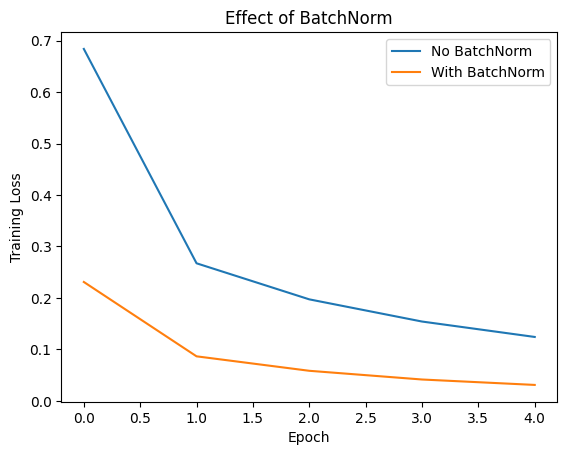

In [5]:
# Setup
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(42)

# ---------- Data ----------
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# ---------- Models ----------
class NetNoBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

class NetWithBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)

# ---------- Training function ----------
def train(model, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    losses=[]
    for epoch in range(epochs):
        total=0
        for X,y in train_loader:
            optimizer.zero_grad()
            out=model(X)
            loss=criterion(out,y)
            loss.backward()
            optimizer.step()
            total += loss.item()
        losses.append(total/len(train_loader))
        print("Epoch:", epoch + 1)
    return losses

loss_no_bn = train(NetNoBN(), epochs=5)
loss_with_bn = train(NetWithBN(), epochs=5)

plt.plot(loss_no_bn,label="No BatchNorm")
plt.plot(loss_with_bn,label="With BatchNorm")
plt.xlabel("Epoch"); plt.ylabel("Training Loss")
plt.legend(); plt.title("Effect of BatchNorm")
plt.show()


Exercises

1) Core (10–15 min)
Task: Try learning rate = 1.2 (very high). Which model trains stably?

Model with no BN
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Model with BN
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


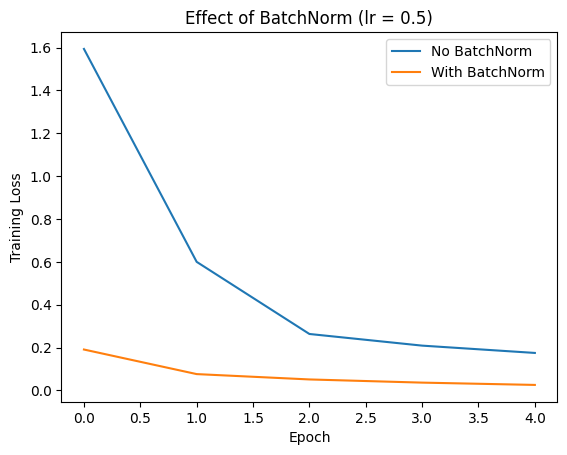

In [ ]:
# ---------- Training function ----------
def train2(model, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=1.2)
    losses=[]
    for epoch in range(epochs):
        total=0
        for X,y in train_loader:
            optimizer.zero_grad()
            out=model(X)
            loss=criterion(out,y)
            loss.backward()
            optimizer.step()
            total += loss.item()
        losses.append(total/len(train_loader))
        print("Epoch:", epoch + 1)
    return losses

print("Model with no BN")
loss_no_bn = train2(NetNoBN(), epochs=5)

print("Model with BN")
loss_with_bn = train2(NetWithBN(), epochs=5)

plt.plot(loss_no_bn,label="No BatchNorm")
plt.plot(loss_with_bn,label="With BatchNorm")
plt.xlabel("Epoch"); plt.ylabel("Training Loss")
plt.legend(); plt.title("Effect of BatchNorm (lr = 1.2)")
plt.show()

The model with batch form reaches converges much faster.

2) Practice (10–15 min)
Task: Swap initialization:
nn.init.kaiming_normal_(model.fc1.weight)   # He init

Deafault initialization 
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
He normal initialization
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6


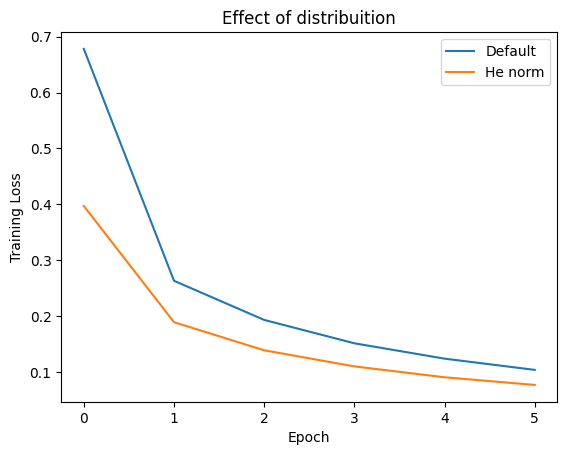

In [6]:

def init_he_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)    # He normal (vs PyTorch default He uniform)
        nn.init.zeros_(m.bias)

m_nobn_default = NetNoBN()                      # default init: He uniform
m_nobn_henorm  = NetNoBN()
m_nobn_henorm.apply(init_he_normal)


epochs = 6
print("Deafault initialization ")
nobn_def_loss = train(m_nobn_default, epochs)

print("He normal initialization")
nobn_hen_loss = train(m_nobn_henorm,  epochs)

plt.plot(nobn_def_loss,label="Default")
plt.plot(nobn_hen_loss,label="He norm")
plt.xlabel("Epoch"); plt.ylabel("Training Loss")
plt.legend(); plt.title("Effect of distribuition")
plt.show()

With He normal, the first layer outputs are more “balanced” → neither vanishing nor exploding.

That means gradients flow better in early training → faster drop in loss.

Over many epochs, both inits usually converge similarly, but the smoother start gives He normal an edge early.

3) Stretch (optional, 10–15 min)
Task: Train a deep network (5+ hidden layers) with and without BN. Does the BN model converge while the other struggles?

Model with no BN
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Model with BN
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


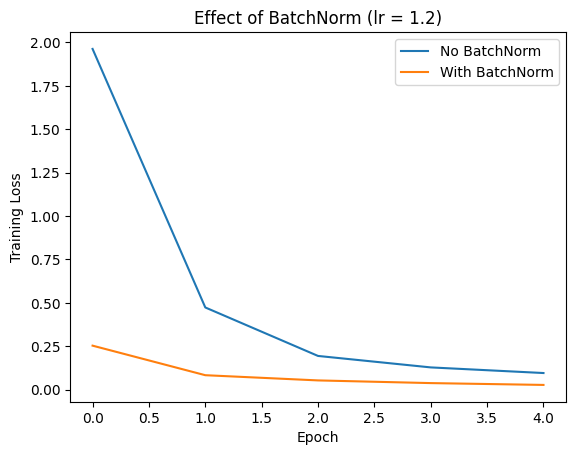

In [7]:
class NetNoBN_7Layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 10)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        return self.fc6(x)

class NetWithBN_7Layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.fc6 = nn.Linear(32, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.relu(self.bn5(self.fc5(x)))
        return self.fc6(x)
    

print("Model with no BN")
loss_no_bn = train(NetNoBN_7Layer(), epochs=5)

print("Model with BN")
loss_with_bn = train(NetWithBN_7Layer(), epochs=5)

plt.plot(loss_no_bn,label="No BatchNorm")
plt.plot(loss_with_bn,label="With BatchNorm")
plt.xlabel("Epoch"); plt.ylabel("Training Loss")
plt.legend(); plt.title("Effect of BatchNorm (lr = 1.2)")
plt.show()

The BN model convergees much faster.

Mini-Challenge (≤40 min)

Task: Build a 5-layer MLP (784→512→256→128→64→10) on MNIST.

Train once with default init, no BN.

Train again with He init + BN after each hidden layer.
Acceptance Criteria:

Plot both loss curves.

Report final validation accuracy.

Brief note on how BN and init improved training stability.

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12


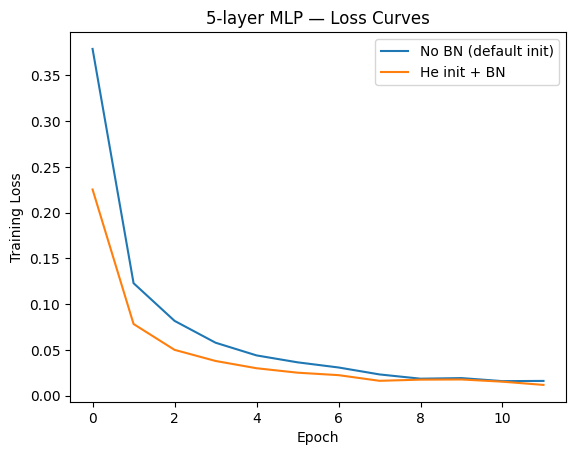

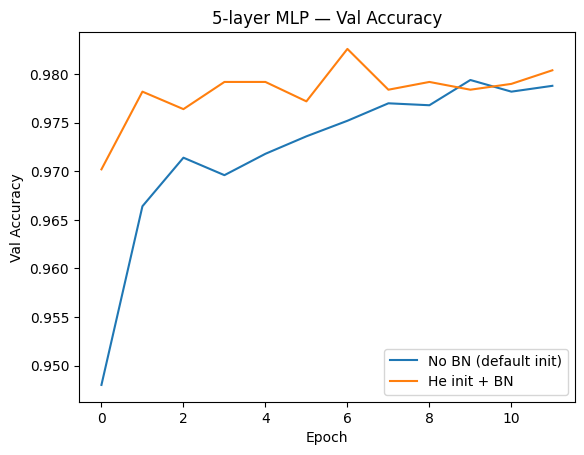

Final Val Acc — No BN (default init): 0.9788
Final Val Acc — He init + BN:        0.9804


In [9]:
from torch.utils.data import random_split

transform = transforms.Compose([transforms.ToTensor()])
full_train = datasets.MNIST(root="data", train=True, download=True, transform=transform)
train_ds, val_ds = random_split(full_train, [55000, 5000])
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=1000)

# ---------- Models ----------
class MLP_NoBN(nn.Module):
    # 784→512→256→128→64→10
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        return self.fc5(x)

class MLP_HeBN(nn.Module):
    # 784→512→256→128→64→10 + BN after each hidden layer
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512); self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256);   self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128);   self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64);    self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.apply(self._he_init)  # He init everywhere

    @staticmethod
    def _he_init(m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)  # He normal (good for ReLU)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.bn4(self.fc4(x)))
        return self.fc5(x)

# ---------- Train / Eval ----------
def train_eval(model, epochs=10, lr=0.001, wd=0.0):
    criterion = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    train_losses, val_accs = [], []

    for i in range(epochs):
        model.train()
        total = 0.0
        for X, y in train_loader:
            opt.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            opt.step()
            total += loss.item()
        train_losses.append(total / len(train_loader))
        print("Epoch: ", i + 1)

        # validation accuracy
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for X, y in val_loader:
                preds = model(X).argmax(1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        val_accs.append(correct / total)

    return train_losses, val_accs

# ---------- Run ----------
epochs = 12
model_a = MLP_NoBN()            # default init (He-uniform) + no BN
loss_a, acc_a = train_eval(model_a, epochs=epochs, lr=0.001)

model_b = MLP_HeBN()            # He-normal + BN after each hidden layer
loss_b, acc_b = train_eval(model_b, epochs=epochs, lr=0.001)

# ---------- Plots ----------
plt.plot(loss_a, label="No BN (default init)")
plt.plot(loss_b, label="He init + BN")
plt.xlabel("Epoch"); plt.ylabel("Training Loss"); plt.title("5-layer MLP — Loss Curves")
plt.legend(); plt.show()

plt.plot(acc_a, label="No BN (default init)")
plt.plot(acc_b, label="He init + BN")
plt.xlabel("Epoch"); plt.ylabel("Val Accuracy"); plt.title("5-layer MLP — Val Accuracy")
plt.legend(); plt.show()

print(f"Final Val Acc — No BN (default init): {acc_a[-1]:.4f}")
print(f"Final Val Acc — He init + BN:        {acc_b[-1]:.4f}")

He initialization keeps activations well-scaled at the start, so gradients don’t vanish/explode.

BatchNorm stabilizes training by re-centering/scaling activations each batch, which allows smoother optimization and slightly better generalization.

The accuracy curves are “noisy” with BN, but overall convergence is faster and performance slightly higher.

Reflection

Why does BatchNorm let us use higher learning rates?

Why is He initialization a better match for ReLU activations than Xavier?

1. Why does BatchNorm let us use higher learning rates?

BN normalizes each layer’s activations → keeps them in a stable range.

This prevents gradients from exploding or vanishing, even when updates are large.

As a result, you can safely use higher learning rates → faster convergence.

2. Why is He initialization a better match for ReLU activations than Xavier?

ReLU “kills” half the inputs (all negatives → 0), so the effective variance is reduced.

Xavier assumes activations are symmetric (tanh/sigmoid) and doesn’t account for this.

He initialization compensates by scaling variance by 2/n, keeping signal strength balanced through layers → more stable gradients with ReLU.

When we talk about **variance in initialization**, it’s the **variance of the activations (outputs of neurons)** as they pass through the layers.

Let me break it down:

* Each neuron computes:

  $$
  a = w \cdot x + b
  $$

  where $x$ = inputs, $w$ = weights, $b$ = bias.

* If the weights are chosen badly, the **distribution of activations $a$** will either:

  * shrink layer by layer → variance goes to **0** → activations all look the same → **vanishing gradients**,
  * blow up layer by layer → variance grows huge → unstable/exploding gradients.

* **Xavier init** tries to keep the variance of activations the *same* from one layer to the next (works well for tanh/sigmoid).

* **He init** does the same, but with extra scaling to compensate for ReLU dropping half the values to 0.

So:
👉 The “variance” we’re preserving is **the spread of neuron outputs across the network** (how wide the distribution is). Keeping this stable ensures signals don’t die out or explode as they move forward and backward.